# Conditional Image Generation

In this tutorial, we will get to know:
- basic knowledge regarding conditional image generation.
- two typical image-to-image translation methods - pix2pix (with paired training data) and CycleGAN (with unpaired training data).
- perform inference with a pretrained MMEditing synthesizer.
- train a new MMEditing synthesizer.

Let's get started!

In [1]:
# you can choose to mount your Google Drive (optional)

# from google.colab import drive
# drive.mount('/content/drive')
# # drive.flush_and_unmount()

## Introduction
Let's first recap some background knowledge about conditional image generation.

Different from unconditional image generation that synthesizes images from a noise map in the latent space, conditional image generation usually synthesizes images from another set of images, namely "condition". Typically, conditional image generation is called "image-to-image translation".

Image-to-image translation tasks can also be divided into two types: **paired** and **unpaired**. The former usually contains paired image data in the training set therefore is data-dependant, but it is easier for image synthesis; the latter does not need paired training data hence more data-independent, but it is challenging to synthesize photorealistic images.

In this tutorial, we will focus on two methods, **pix2pix** for paired image-to-image translation and **CycleGAN** for unpaired image-to-image translation, to learn how to generate high-fidelity images.

## Install MMEditing

In [2]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmediting, full instructions in: https://github.com/open-mmlab/mmediting/blob/master/docs/install.md.
!rm -rf mmediting
!git clone https://github.com/open-mmlab/mmediting.git
%cd mmediting

# install other dependencies
!pip install -r requirements.txt
!pip install -v -e .  # or "python setup.py develop"

# show the installed packages
!pip list

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 103kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
Cloning into 'mmediting'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 4686 (delta 2), reused 6 (delta 1), pack-reused 4676
Receiving objects: 100% (4686/4686), 3.59 MiB | 6.27 MiB/s, done.
Resolving deltas: 100% (3228/3228), done.
/content/mmediting
     |████████████████████████████████| 245kB 8.9MB/s 
     |████████████████████████████████| 194kB 15.9MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |█████████

In [4]:
# check PyTorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# check MMEditing installation
import mmedit
print(mmedit.__version__)

# check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
0.5.0
10.1
GCC 7.5


In [5]:
# show the current folder
!ls

configs  docs	  mmedit.egg-info  requirements.txt  setup.py
demo	 LICENSE  README.md	   resources	     tests
docker	 mmedit   requirements	   setup.cfg	     tools


## Dataset Preparation

We need to prepare our datasets before performing inference and training to synthesize images. The preparation for conditional image generation is very easy. You can directly download **paired** datasets from [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/), and **unpaired** datasets from [here](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/). Then, you need to unzip and move corresponding datasets in accordance to the folder structure shown below. 

(You can also just simply run the code below to download and prepare the datasets used in this tutorial)
```
mmediting
├── mmedit
├── tools
├── configs
├── data
│    ├── paired
│    │    ├── facades
│    │    ├── maps
│    │    ├── edges2shoes
│    │    │    ├── train
│    │    │    ├── test
│    ├── unpaired
│    │    ├── facades
│    │    ├── horse2zebra
│    │    ├── summer2winter_yosemite
│    │    │    ├── trainA
│    │    │    ├── trainB
│    │    │    ├── testA
│    │    │    ├── testB
```

As we only need images and the correct folder structure for generation task, further preparation is not necessary. For paired datasets, each sample should be paired images that are concatenated in the width dimension. For unpaired datasets, `trainA` and `testA` contain images from domain A, whereas `trainB` and `testB` contain images from domain B. We recommend you to download the existing datasets directly and conduct experiments. Or you can just put your images in the right place.

Here are some code you can directly run to download and prepare the **facades** (paired) and **horse2zebra** (unpaired) datasets:

In [6]:
# create the './data/' folder and enter it
!mkdir -p data/
%cd data/

/content/mmediting/data


In [7]:
# download the paired dataset 'facades' and unzip it
!mkdir -p paired/
%cd paired/
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xf facades.tar.gz
!rm -f facades.tar.gz

/content/mmediting/data/paired
--2020-10-14 03:56:40--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  3.63MB/s    in 16s     

2020-10-14 03:56:57 (1.80 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



Here, we have downloaded a small paired dataset **facades** containing paired images concatenated in the width dimension. Let's look at the directory structure and visualize an example:

In [8]:
# install tree first
!apt-get -q install tree

# show the directory structure
!tree facades

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (755 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144617 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
facades
├── test
│   ├── 100.jpg
│   ├── 101.jpg
│   ├── 102.jpg
│   ├── 103.jpg
│   ├── 104.jpg
│   ├── 105.jpg
│   ├── 106.jpg
│   ├── 10.jpg
│   ├── 11.jpg
│   ├── 12.jpg
│   ├── 13.jpg
│   ├── 14.jpg
│   ├── 15.jpg
│   ├── 16.jpg
│   ├── 17.jpg
│   ├── 18.jpg
│   ├── 19.jpg
│   ├── 1.jpg
│ 

Facades paired image size: (256, 512, 3)


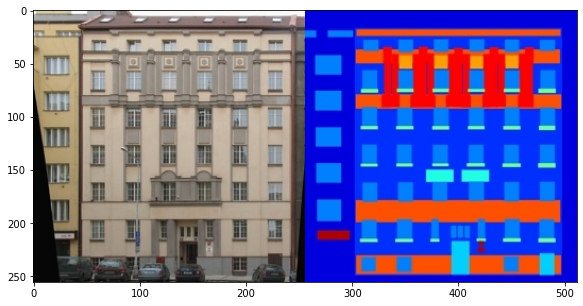

In [9]:
import matplotlib.pyplot as plt
import mmcv

# read the paired image
img = mmcv.imread('./facades/test/1.jpg')

# show the paired image size
print(f'Facades paired image size: {img.shape}')

# visualize the test image 
plt.figure(figsize=(10, 5))  # set figure size

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(img))

Note that this is a **single** image comprising a pair of images. On the left is a real-scene image (the ground truth), and on the right is its corresponding semantic segmentation mask. We usually consider how to generate a photorealistic image from a mask, i.e., right -> left.

In [10]:
%cd ..
!mkdir unpaired/
%cd unpaired/
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip --no-check-certificate
!unzip -qq horse2zebra.zip
!rm -f horse2zebra.zip

/content/mmediting/data
/content/mmediting/data/unpaired
--2020-10-14 03:58:13--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  15.5MB/s    in 13s     

2020-10-14 03:58:27 (8.50 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



Here, we have downloaded an unpaired dataset **horse2zebra** that contains unpaired images (two images, not concatenated). Let's look at the directory structure and visualize an example:

In [11]:
# show the directory structure
!tree horse2zebra

horse2zebra
├── testA
│   ├── n02381460_1000.jpg
│   ├── n02381460_1010.jpg
│   ├── n02381460_1030.jpg
│   ├── n02381460_1090.jpg
│   ├── n02381460_1100.jpg
│   ├── n02381460_1110.jpg
│   ├── n02381460_1120.jpg
│   ├── n02381460_1160.jpg
│   ├── n02381460_120.jpg
│   ├── n02381460_1210.jpg
│   ├── n02381460_1260.jpg
│   ├── n02381460_1300.jpg
│   ├── n02381460_1350.jpg
│   ├── n02381460_1360.jpg
│   ├── n02381460_140.jpg
│   ├── n02381460_1420.jpg
│   ├── n02381460_1540.jpg
│   ├── n02381460_1620.jpg
│   ├── n02381460_1630.jpg
│   ├── n02381460_1660.jpg
│   ├── n02381460_1690.jpg
│   ├── n02381460_1740.jpg
│   ├── n02381460_1750.jpg
│   ├── n02381460_180.jpg
│   ├── n02381460_1820.jpg
│   ├── n02381460_1830.jpg
│   ├── n02381460_1870.jpg
│   ├── n02381460_1920.jpg
│   ├── n02381460_200.jpg
│   ├── n02381460_2050.jpg
│   ├── n02381460_20.jpg
│   ├── n02381460_2100.jpg
│   ├── n02381460_2120.jpg
│   ├── n02381460_2150.jpg
│   ├── n02381460_2280.jpg
│   ├── n02381460_2460.jpg
│   ├── n023

Horse image size: (256, 256, 3)
Zebra image size: (256, 256, 3)


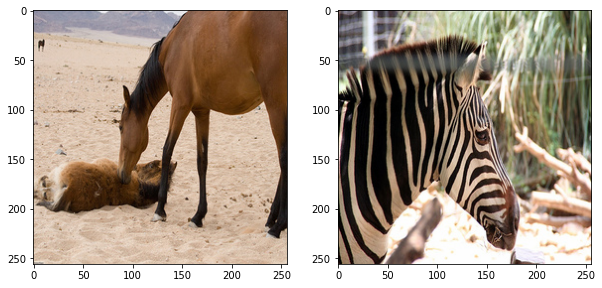

In [12]:
import matplotlib.pyplot as plt
import mmcv

# read the unpaired image
img_horse = mmcv.imread('./horse2zebra/testA/n02381460_1110.jpg')
img_zebra = mmcv.imread('./horse2zebra/testB/n02391049_860.jpg')

# show the unpaired image size
print(f'Horse image size: {img_horse.shape}')
print(f'Zebra image size: {img_zebra.shape}')

# visualize the test image 
fig = plt.figure(figsize=(10, 5))  # set figure size
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, the left image  
ax2 = fig.add_subplot(1, 2, 2)  # 1 row, 2 columns, the right image  

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
ax1.imshow(mmcv.bgr2rgb(img_horse))
ax2.imshow(mmcv.bgr2rgb(img_zebra))

Note that these are **two** images that are unpaired (not concatenated).

In [13]:
# change the directory back to the root of MMEditing
%cd ../..
!ls

/content/mmediting
configs  docker   mmedit	   requirements      setup.cfg	tools
data	 docs	  mmedit.egg-info  requirements.txt  setup.py
demo	 LICENSE  README.md	   resources	     tests


## Inference with A Pretrained MMEditing Synthesizer

MMEditing has already provided some high-level APIs to do the inference.

First, let's download the pretrained synthesizer models regarding the facades (pix2pix) and horse2zebra (CycleGAN) datasets.

In [14]:
# download relevant models
!mkdir checkpoints
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/synthesizers/pix2pix/pix2pix_facades/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth \
      -O checkpoints/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/synthesizers/cyclegan/cyclegan_horse2zebra/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth \
      -O checkpoints/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth

--2020-10-14 03:58:53--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/synthesizers/pix2pix/pix2pix_facades/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth
Resolving openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)... 47.254.186.225
Connecting to openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228800928 (218M) [application/octet-stream]
Saving to: ‘checkpoints/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth’

checkpoints/pix2pix 100%[===================>] 218.20M  6.54MB/s    in 33s     

2020-10-14 03:59:28 (6.54 MB/s) - ‘checkpoints/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth’ saved [228800928/228800928]

--2020-10-14 03:59:28--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/synthesizers/cyclegan/cyclegan_horse2zebra/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-

In [15]:
# show the model names
!ls checkpoints/

cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth
pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth


### Paired Image-to-Image Translation (pix2pix)

#### Network Structure

The difference between unconditional and conditional image generation is that the latter maps images to images, rather than the latent noise to images. Thus, in conditional image generation, the generator structure also includes an encoder that maps the image to the latent space.

**Pix2pix** first presents the "image-to-image translation" problem, and it uses paired training data. There are two choices for the architecture of the generator:

![pix2pixgenerator](https://drive.google.com/uc?export=view&id=196YecwMvEGlN02lztH7XnQG03izEhMgM)

On the left is a typical "encoder-decoder" generator, and on the right is the "U-Net" generator. The "U-Net" is an encoder-decoder with skip connections between mirrored layers in the encoder and decoder stacks. We mainly implement the "U-Net" generator in pix2pix, because it usually achieves better performance compared with the common "encoder-decoder" generator.

In [16]:
# initialize the model and print network structure specifics
from mmedit.apis import init_model

# specify the config file
config = 'configs/synthesizers/pix2pix/pix2pix_vanilla_unet_bn_1x1_80k_facades.py'

# setup the checkpoint file to load
checkpoint = 'checkpoints/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth'

# initialize the synthesizer model
model = init_model(config, checkpoint, device='cuda:0')

# see the model details to match the above framework (using the "U-Net" generator)
print(model)

Pix2Pix(
  (generator): UnetGenerator(
    (model): UnetSkipConnectionBlock(
      (model): Sequential(
        (0): ConvModule(
          (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        )
        (1): UnetSkipConnectionBlock(
          (model): Sequential(
            (0): ConvModule(
              (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activate): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (1): UnetSkipConnectionBlock(
              (model): Sequential(
                (0): ConvModule(
                  (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activate): LeakyReLU(negative_slope=0.2, i

#### Regular Inference (show the input images)

float32
uint8


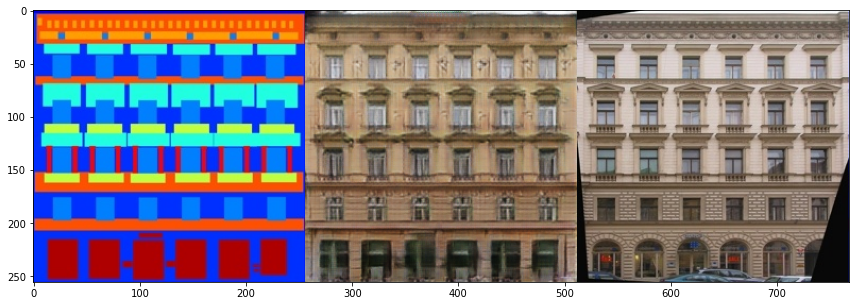

In [17]:
# perform inference and show the results (including the input)
import mmcv
import numpy as np

from mmedit.apis import generation_inference

# specify the test image (paired, concatenated in the width dimension) path
img_path = './data/paired/facades/test/10.jpg'

# perform inference using the high-level api
result = generation_inference(model, img_path)
print(result.dtype)

# constrain the range to [0, 255], and convert the result from float32 to uint8
result = np.clip(result, 0, 255)
result = result.astype(np.uint8)
print(result.dtype)

# visualize the test image 
plt.figure(figsize=(15, 5))  # set figure size

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result))

Here, we get the result images concatenated in the width dimension. That is because we specify `show_input=True` in our config file. Later, we will learn how to show a single synthesized result image during inference.

As mentioned earlier, we hope to generate a real-scene image from its corresponding semantic segmentation mask on the facades dataset. The leftmost image is the **input segmentation mask**. Can you distinguish which one of the other two images is the generated image? :-)

The rightmost image is our **ground truth image**. The image in the middle is the **fake image** generated by our pix2pix pretained model - it does look very photorealistic, doesn't it? (Some black edges in the ground truth image are a result of  image cropping done by the dataset authors; the cropping do not affect the image generation much).

#### Modify Inference Config (Input Images Not Shown)

Sometimes, we only need the generated image and we do not need the real input image. Here, let's start to learn how to **modify the config file** and perform inference to **show a single synthesized result** image.

In [18]:
import mmcv
import numpy as np

from mmcv import Config
from mmedit.apis import generation_inference, init_model

# specify the config file
config = 'configs/synthesizers/pix2pix/pix2pix_vanilla_unet_bn_1x1_80k_facades.py'

# setup the checkpoint file to load
checkpoint = 'checkpoints/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth'

# load the inference config file
cfg = Config.fromfile(config)

# show current config
print(f'Config before modification:\n{cfg.pretty_text}')

Config before modification:
model = dict(
    type='Pix2Pix',
    generator=dict(
        type='UnetGenerator',
        in_channels=3,
        out_channels=3,
        num_down=8,
        base_channels=64,
        norm_cfg=dict(type='BN'),
        use_dropout=True,
        init_cfg=dict(type='normal', gain=0.02)),
    discriminator=dict(
        type='PatchDiscriminator',
        in_channels=6,
        base_channels=64,
        num_conv=3,
        norm_cfg=dict(type='BN'),
        init_cfg=dict(type='normal', gain=0.02)),
    gan_loss=dict(
        type='GANLoss',
        gan_type='vanilla',
        real_label_val=1.0,
        fake_label_val=0.0,
        loss_weight=1.0),
    pixel_loss=dict(type='L1Loss', loss_weight=100.0, reduction='mean'))
train_cfg = dict(direction='b2a')
test_cfg = dict(direction='b2a', show_input=True)
train_dataset_type = 'GenerationPairedDataset'
val_dataset_type = 'GenerationPairedDataset'
img_norm_cfg = dict(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
train_pi

In [19]:
# modify the config file (set test_cfg.show_input = False)
cfg.test_cfg.show_input = False

# show current config
print(f'Config after modification:\n{cfg.pretty_text}')

Config after modification:
model = dict(
    type='Pix2Pix',
    generator=dict(
        type='UnetGenerator',
        in_channels=3,
        out_channels=3,
        num_down=8,
        base_channels=64,
        norm_cfg=dict(type='BN'),
        use_dropout=True,
        init_cfg=dict(type='normal', gain=0.02)),
    discriminator=dict(
        type='PatchDiscriminator',
        in_channels=6,
        base_channels=64,
        num_conv=3,
        norm_cfg=dict(type='BN'),
        init_cfg=dict(type='normal', gain=0.02)),
    gan_loss=dict(
        type='GANLoss',
        gan_type='vanilla',
        real_label_val=1.0,
        fake_label_val=0.0,
        loss_weight=1.0),
    pixel_loss=dict(type='L1Loss', loss_weight=100.0, reduction='mean'))
train_cfg = dict(direction='b2a')
test_cfg = dict(direction='b2a', show_input=False)
train_dataset_type = 'GenerationPairedDataset'
val_dataset_type = 'GenerationPairedDataset'
img_norm_cfg = dict(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
train_pi

float32
uint8


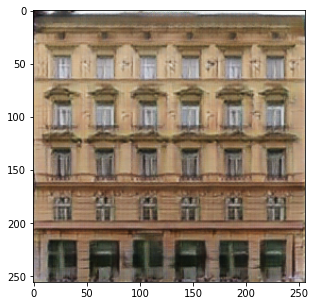

In [20]:
# then, perform similar steps as the regular inference using the new config

# initialize the synthesizer model using the new config
model = init_model(cfg, checkpoint, device='cuda:0')

# specify the test image (paired, concatenated in the width dimension) path
img_path = './data/paired/facades/test/10.jpg'

# perform inference using the high-level api
result = generation_inference(model, img_path)
print(result.dtype)

# constrain the range to [0, 255], and convert the result from float32 to uint8
result = np.clip(result, 0, 255)
result = result.astype(np.uint8)
print(result.dtype)

# visualize the test image 
plt.figure(figsize=(5, 5))  # set figure size

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result))

Finally, we get our single synthesized image without the real image as input!

### Unpaired Image-to-Image Translation (CycleGAN)

#### Network Structure

**CycleGAN** is an important GAN model for unpaired image-to-image translation. For many tasks, paired training data will not be available. Different from pix2pix, CycleGAN requires only unpaired training data. The task is data-independent but more challenging.

Our goal is to learn a mapping G: X → Y using an adversarial loss, such that the distribution of images from G(X) is indistinguishable from the distribution Y. Because this mapping is highly under-constrained, CycleGAN couples it with an inverse mapping F: Y → X and introduces a *cycle consistency loss* to enforce F(G(X)) ≈ X (and vice versa).

To achieve this, CycleGAN consists of a pair of generators and discriminators:

![cycleganstructure](https://drive.google.com/uc?export=view&id=1QLp8kfrDx3o7zU0vAg_6fDqD6gt6iM3A)

(a) CycleGAN contains two mapping functions G: X → Y and F: Y → X, and two adversarial discriminators $D_Y$ and $D_X$. $D_Y$ encourages G to translate X into outputs indistinguishable from domain Y, while $D_X$ encourages G to translate Y into outputs indistinguishable from domain X. To further regularize the mappings, CycleGAN introduces two *cycle consistency* losses that capture the intuition that if we translate from one domain to the other and back again, we should arrive at where we started: (b) forward cycle-consistency loss: x → G(x) → F(G(x)) ≈ x, and (c) backward cycle-consistency loss: y → F(y) → G(F(y)) ≈ y.

CycleGAN model is much more complex than pix2pix, as the former incorporates more networks and more complicated network structures, as well as having additional constraint (*cycle consistency*). However, it gains stronger ability in the more challenging task of unpaired image-to-image translation.

In [21]:
# initialize the model and print network structure specifics
from mmedit.apis import init_model

# specify the config file
config = 'configs/synthesizers/cyclegan/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra.py'

# setup the checkpoint file to load
checkpoint = 'checkpoints/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth'

# initialize the synthesizer model
model = init_model(config, checkpoint, device='cuda:0')

# see the model details to match the above framework
print(model)

/usr/local/lib/python3.6/dist-packages/mmcv/cnn/bricks/conv_module.py:100: UserWarning: ConvModule has norm and bias at the same time
  warnings.warn('ConvModule has norm and bias at the same time')


CycleGAN(
  (generators): ModuleDict(
    (a): ResnetGenerator(
      (model): Sequential(
        (0): ConvModule(
          (padding_layer): ReflectionPad2d((3, 3, 3, 3))
          (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
          (in): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (activate): ReLU(inplace=True)
        )
        (1): ConvModule(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (in): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (activate): ReLU(inplace=True)
        )
        (2): ConvModule(
          (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (in): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (activate): ReLU(inplace=True)
        )
        (3): ResidualBlockWithDropout(
          (block): Sequential(
           

From the print out of the network structure details, we can see that CycleGAN is much more complicated than pix2pix.

#### Regular Inference (Input Images Shown)

Because CycleGAN contains a pair of generators and discriminators, we can perform forward and backward image generation between two unpaired domains at the same time during inference. Similar to pix2pix, let's first perform regular inference using the default config setting. Note that, here, 'horse' is domain A, and 'zebra' is domain B.

float32
uint8


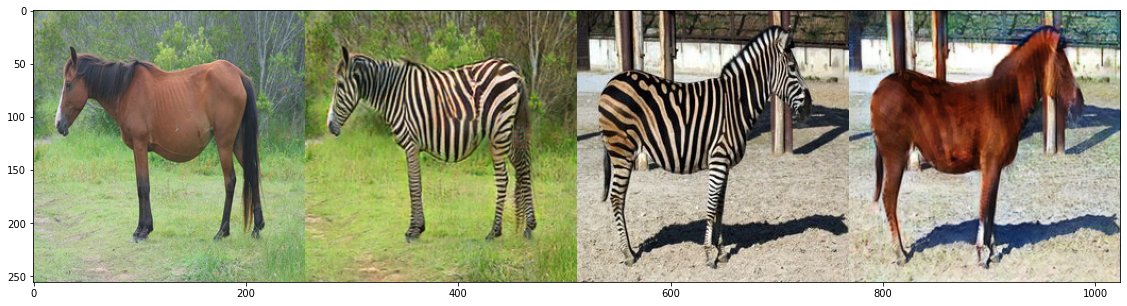

In [23]:
# perform inference and show the results (including the input)
import mmcv
import numpy as np

from mmedit.apis import generation_inference

# specify the test image (two unpaired images) paths
img_a_path = './data/unpaired/horse2zebra/testA/n02381460_4530.jpg'
img_b_path = './data/unpaired/horse2zebra/testB/n02391049_3290.jpg'

# perform inference using the high-level api
result = generation_inference(model, img_a_path, img_b_path)
print(result.dtype)

# constrain the range to [0, 255], and convert the result from float32 to uint8
result = np.clip(result, 0, 255)
result = result.astype(np.uint8)
print(result.dtype)

# visualize the test image 
plt.figure(figsize=(20, 5))  # set figure size

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result))

Here, we get the result images concatenated in the width dimension. The input images are also shown because we specify `show_input=True` in our config file.

Images from left to right are the **real horse**, **fake zebra**, **real zebra**, **fake horse**, respectively.

Here, domain A contains the real horse and domain B has the real zebra, and these real images are **unpaired**. We translate images from domain A to domain B (i.e., horse → zebra) and vice versa. Despite the difficulty of performming unpaired image-to-image translation, the results are not bad!

#### Modify Inference Config (Input Images Not Shown)

Similarly, we can modify the config file of CycleGAN and perform inference to show a single synthesized image. Since we have already got some prior experience, let’s skip some display and look at the code directly.

/usr/local/lib/python3.6/dist-packages/mmcv/cnn/bricks/conv_module.py:100: UserWarning: ConvModule has norm and bias at the same time
  warnings.warn('ConvModule has norm and bias at the same time')


float32
uint8


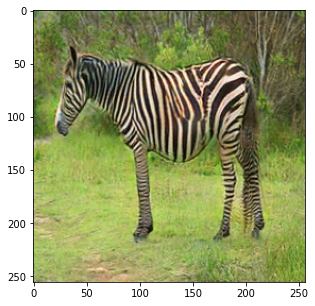

In [25]:
import mmcv
import numpy as np

from mmcv import Config
from mmedit.apis import generation_inference, init_model

# specify the config file
config = 'configs/synthesizers/cyclegan/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra.py'

# setup the checkpoint file to load
checkpoint = 'checkpoints/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth'

# load the inference config file
cfg = Config.fromfile(config)

# modify the config file (setting test_cfg.show_input = False)
cfg.test_cfg.show_input = False

# initialize the synthesizer model using the new config
model = init_model(cfg, checkpoint, device='cuda:0')

# specify the test image (two unpaired images) paths
img_a_path = './data/unpaired/horse2zebra/testA/n02381460_4530.jpg'
img_b_path = './data/unpaired/horse2zebra/testB/n02391049_3290.jpg'

# perform inference using the high-level api
result = generation_inference(model, img_a_path, img_b_path)
print(result.dtype)

# constrain the range to [0, 255], and convert the result from float32 to uint8
result = np.clip(result, 0, 255)
result = result.astype(np.uint8)
print(result.dtype)

# visualize the test image 
plt.figure(figsize=(5, 5))  # set figure size

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result))

#### Modify Inference Config (Input Image Not Shown; Perform Inverse Translation)

For CycleGAN, we can also modify the config file and perform inference to show an inverse translated image, i.e., domain B -> A. (zebra → horse) with the same single model.

In [26]:
import mmcv
import numpy as np

from mmcv import Config
from mmedit.apis import generation_inference, init_model

# specify the config file
config = 'configs/synthesizers/cyclegan/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra.py'

# setup the checkpoint file to load
checkpoint = 'checkpoints/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth'

# load the inference config file
cfg = Config.fromfile(config)

# show current config
print(f'Config before modification:\n{cfg.pretty_text}')

Config before modification:
model = dict(
    type='CycleGAN',
    generator=dict(
        type='ResnetGenerator',
        in_channels=3,
        out_channels=3,
        base_channels=64,
        norm_cfg=dict(type='IN'),
        use_dropout=False,
        num_blocks=9,
        padding_mode='reflect',
        init_cfg=dict(type='normal', gain=0.02)),
    discriminator=dict(
        type='PatchDiscriminator',
        in_channels=3,
        base_channels=64,
        num_conv=3,
        norm_cfg=dict(type='IN'),
        init_cfg=dict(type='normal', gain=0.02)),
    gan_loss=dict(
        type='GANLoss',
        gan_type='lsgan',
        real_label_val=1.0,
        fake_label_val=0.0,
        loss_weight=1.0),
    cycle_loss=dict(type='L1Loss', loss_weight=10.0, reduction='mean'),
    id_loss=dict(type='L1Loss', loss_weight=0.5, reduction='mean'))
train_cfg = dict(direction='a2b', buffer_size=50)
test_cfg = dict(direction='a2b', show_input=True)
train_dataset_type = 'GenerationUnpairedData

In [27]:
# modify the config file (set test_cfg.show_input = False)
cfg.test_cfg.show_input = False

# and we also need to set test_cfg.test_direction = 'b2a' (the default value is 'a2b')
cfg.test_cfg.test_direction = 'b2a'

# show current config
print(f'Config after modification:\n{cfg.pretty_text}')

Config after modification:
model = dict(
    type='CycleGAN',
    generator=dict(
        type='ResnetGenerator',
        in_channels=3,
        out_channels=3,
        base_channels=64,
        norm_cfg=dict(type='IN'),
        use_dropout=False,
        num_blocks=9,
        padding_mode='reflect',
        init_cfg=dict(type='normal', gain=0.02)),
    discriminator=dict(
        type='PatchDiscriminator',
        in_channels=3,
        base_channels=64,
        num_conv=3,
        norm_cfg=dict(type='IN'),
        init_cfg=dict(type='normal', gain=0.02)),
    gan_loss=dict(
        type='GANLoss',
        gan_type='lsgan',
        real_label_val=1.0,
        fake_label_val=0.0,
        loss_weight=1.0),
    cycle_loss=dict(type='L1Loss', loss_weight=10.0, reduction='mean'),
    id_loss=dict(type='L1Loss', loss_weight=0.5, reduction='mean'))
train_cfg = dict(direction='a2b', buffer_size=50)
test_cfg = dict(direction='a2b', show_input=False, test_direction='b2a')
train_dataset_type = '

/usr/local/lib/python3.6/dist-packages/mmcv/cnn/bricks/conv_module.py:100: UserWarning: ConvModule has norm and bias at the same time
  warnings.warn('ConvModule has norm and bias at the same time')


float32
uint8


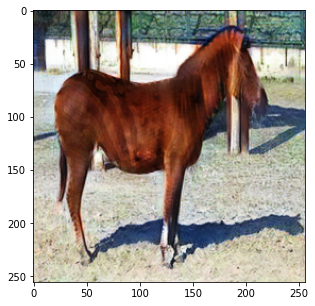

In [28]:
# then, perform similar steps as the regular inference using the new config

# initialize the synthesizer model using the new config
model = init_model(cfg, checkpoint, device='cuda:0')

# specify the test image (two unpaired images) paths
img_a_path = './data/unpaired/horse2zebra/testA/n02381460_4530.jpg'
img_b_path = './data/unpaired/horse2zebra/testB/n02391049_3290.jpg'

# perform inference using the high-level api
result = generation_inference(model, img_a_path, img_b_path)
print(result.dtype)

# constrain the range to [0, 255], and convert the result from float32 to uint8
result = np.clip(result, 0, 255)
result = result.astype(np.uint8)
print(result.dtype)

# visualize the test image 
plt.figure(figsize=(5, 5))  # set figure size

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result))

## Train A New Synthesizer

In this tutorial, we will also show you how to train a new MMEditing synthesizer.

Training a deep learning model may need a very long time. Thus, we shall adopt the pretrained models shown earlier and **fine tune** them to produce a training demo. Note also that in generation tasks, model training is **dataset-dependent**. That means we may not achieve good performance if we were to fine tune our model using datasets that are very different.

Therefore, we shall use the validation set (100 images) of facades dataset as the new small training set for pix2pix. For CycleGAN, we fine tune our pretrained model using a small portion of the test set (100 images) of horse2zebra dataset, as there is no validation set for this dataset. The remaining test images will be regarded as the new test set.

### Paired Image-to-Image Translation (pix2pix)

#### Prepare A New Paired Dataset

As described, we need to construct a new paired dataset to fine tune pix2pix pretrained model.

In [29]:
%cd data/paired
!mkdir facades_tiny/
# use the validation set (100 images) of facades dataset as the new small training set
!cp -r facades/val/ facades_tiny/train
# the test set is not changed
!cp -r facades/test/ facades_tiny/test

/content/mmediting/data/paired


In [30]:
# show the directory structure of the newly constructed dataset
!tree facades_tiny

facades_tiny
├── test
│   ├── 100.jpg
│   ├── 101.jpg
│   ├── 102.jpg
│   ├── 103.jpg
│   ├── 104.jpg
│   ├── 105.jpg
│   ├── 106.jpg
│   ├── 10.jpg
│   ├── 11.jpg
│   ├── 12.jpg
│   ├── 13.jpg
│   ├── 14.jpg
│   ├── 15.jpg
│   ├── 16.jpg
│   ├── 17.jpg
│   ├── 18.jpg
│   ├── 19.jpg
│   ├── 1.jpg
│   ├── 20.jpg
│   ├── 21.jpg
│   ├── 22.jpg
│   ├── 23.jpg
│   ├── 24.jpg
│   ├── 25.jpg
│   ├── 26.jpg
│   ├── 27.jpg
│   ├── 28.jpg
│   ├── 29.jpg
│   ├── 2.jpg
│   ├── 30.jpg
│   ├── 31.jpg
│   ├── 32.jpg
│   ├── 33.jpg
│   ├── 34.jpg
│   ├── 35.jpg
│   ├── 36.jpg
│   ├── 37.jpg
│   ├── 38.jpg
│   ├── 39.jpg
│   ├── 3.jpg
│   ├── 40.jpg
│   ├── 41.jpg
│   ├── 42.jpg
│   ├── 43.jpg
│   ├── 44.jpg
│   ├── 45.jpg
│   ├── 46.jpg
│   ├── 47.jpg
│   ├── 48.jpg
│   ├── 49.jpg
│   ├── 4.jpg
│   ├── 50.jpg
│   ├── 51.jpg
│   ├── 52.jpg
│   ├── 53.jpg
│   ├── 54.jpg
│   ├── 55.jpg
│   ├── 56.jpg
│   ├── 57.jpg
│   ├── 58.jpg
│   ├── 59.jpg
│   ├── 5.jpg
│   ├── 60.jpg
│   ├── 61.jpg
│   ├── 62.jpg
│

Facades tiny paired image size: (256, 512, 3)


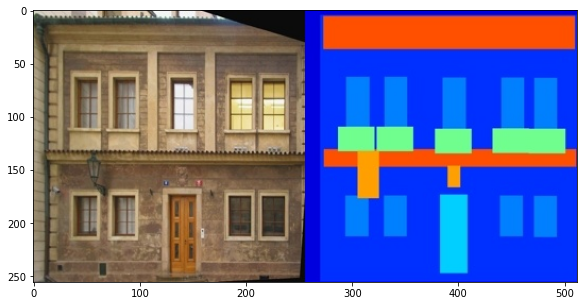

In [31]:
# Also, we can visualize an example
import matplotlib.pyplot as plt
import mmcv

# read the paired image
img = mmcv.imread('./facades_tiny/train/1.jpg')

# show the paired image size
print(f'Facades tiny paired image size: {img.shape}')

# visualize the test image 
plt.figure(figsize=(10, 5))  # set figure size

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(img))

In [32]:
# back to the root and list files
%cd ../..
!ls

/content/mmediting
checkpoints  demo    LICENSE	      README.md		resources  tests
configs      docker  mmedit	      requirements	setup.cfg  tools
data	     docs    mmedit.egg-info  requirements.txt	setup.py


#### Modify the Training Config

After constructing the new dataset 'facade_tiny', we need to modify the config file to train a new synthesizer. To save some time, we only train pix2pix for another 20 epochs.

In [33]:
from mmcv import Config

# specify the config file
config = 'configs/synthesizers/pix2pix/pix2pix_vanilla_unet_bn_1x1_80k_facades.py'

# setup the checkpoint file to fine tune
checkpoint = 'checkpoints/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth'

# load the training config file (the file information has been shown in the inference section)
cfg = Config.fromfile(config)

# modify dataset path (the type and processing pipeline keep unchanged)
cfg.data_root = './data/paired/facades_tiny'
cfg.data.train.dataroot = './data/paired/facades_tiny'
cfg.data.val.dataroot = './data/paired/facades_tiny'
cfg.data.test.dataroot = './data/paired/facades_tiny'

# modify the pretrained model path
cfg.load_from = checkpoint

# modify other training settings
# train for another 20 epochs (2000 iterations)
cfg.total_iters = 2000
# set new working directory
cfg.exp_name = 'pix2pix_facades_tiny'
cfg.work_dir = './tutorial_exps/pix2pix_facades_tiny'
# update checkpoint itervals to accelerate
cfg.checkpoint_config.interval = 2000
# no need for evaluation during training, we can inference after the model is well-trained
# thus, we set a very large value for the interval
cfg.evaluation.interval = 2000000
# set seed for reproducibility
cfg.seed = 1112

# show the training config file
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Pix2Pix',
    generator=dict(
        type='UnetGenerator',
        in_channels=3,
        out_channels=3,
        num_down=8,
        base_channels=64,
        norm_cfg=dict(type='BN'),
        use_dropout=True,
        init_cfg=dict(type='normal', gain=0.02)),
    discriminator=dict(
        type='PatchDiscriminator',
        in_channels=6,
        base_channels=64,
        num_conv=3,
        norm_cfg=dict(type='BN'),
        init_cfg=dict(type='normal', gain=0.02)),
    gan_loss=dict(
        type='GANLoss',
        gan_type='vanilla',
        real_label_val=1.0,
        fake_label_val=0.0,
        loss_weight=1.0),
    pixel_loss=dict(type='L1Loss', loss_weight=100.0, reduction='mean'))
train_cfg = dict(direction='b2a')
test_cfg = dict(direction='b2a', show_input=True)
train_dataset_type = 'GenerationPairedDataset'
val_dataset_type = 'GenerationPairedDataset'
img_norm_cfg = dict(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
train_pipeline = [
    dict(

#### Train A New Pix2pix Synthesizer

In [34]:
import copy
import os
import os.path as osp
import time

import mmcv
import torch
from mmedit import __version__
from mmedit.apis import set_random_seed, train_model
from mmedit.datasets import build_dataset
from mmedit.models import build_model
from mmedit.utils import get_root_logger

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

# set the number of gpus
cfg.gpus = 1

# create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# init the logger before other steps
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

# log some basic info
logger.info('Distributed training: {}'.format(False))
logger.info('mmedit Version: {}'.format(__version__))

# set random seed for reproducibility
logger.info('Set random seed to {}, deterministic: {}'.format(cfg.seed, False))
set_random_seed(cfg.seed, deterministic=False)

# build model
model = build_model(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# build dataset
datasets = [build_dataset(cfg.data.train)]

# prepare some meta information
if cfg.checkpoint_config is not None:
    # save version, config file content and class names in checkpoints as meta data
    cfg.checkpoint_config.meta = dict(
        mmedit_version=__version__,
        config=cfg.text,
    )
meta = dict()
meta['exp_name'] = cfg.exp_name
meta['mmedit Version'] = __version__
meta['seed'] = cfg.seed

# backup the config for inference
cfg_bak = copy.deepcopy(cfg)

# start training a new pix2pix synthesizer!
train_model(model,
            datasets,
            cfg,
            distributed=False,
            validate=False,
            timestamp=timestamp,
            meta=meta)

2020-10-14 04:21:30,361 - mmedit - INFO - Distributed training: False
2020-10-14 04:21:30,362 - mmedit - INFO - mmedit Version: 0.5.0
2020-10-14 04:21:30,363 - mmedit - INFO - Set random seed to 1112, deterministic: False
2020-10-14 04:21:31,987 - mmedit - INFO - load checkpoint from checkpoints/pix2pix_vanilla_unet_bn_1x1_80k_facades_20200524-6206de67.pth
2020-10-14 04:21:32,141 - mmedit - INFO - Start running, host: root@b2a8ae642c6a, work_dir: /content/mmediting/tutorial_exps/pix2pix_facades_tiny
2020-10-14 04:21:32,142 - mmedit - INFO - workflow: [('train', 1)], max: 2000 iters
2020-10-14 04:21:39,852 - mmedit - INFO - Iter [100/2000]	lr_generator: 2.000e-04 lr_discriminator: 2.000e-04, eta: 0:02:23, time: 0.075, data_time: 0.000, memory: 4533, loss_gan_d_fake: 0.2422, loss_gan_d_real: 0.2670, loss_gan_g: 3.6089, loss_pixel: 33.2286
2020-10-14 04:21:47,122 - mmedit - INFO - Iter [200/2000]	lr_generator: 2.000e-04 lr_discriminator: 2.000e-04, eta: 0:02:13, time: 0.073, data_time: 0.

#### Understand the Log

From the log, we can get a basic understanding of the training process and know how well the synthesizer is trained.

From the first few lines, we can see some basic information of our training process, e.g., whether to use distributed training, MMEditing version, random seed, load path, work directory, etc.

By printing out the training status for every 100 iterations, we can observe the learning rates for the generator and discriminator, the estimated time of arrival (`eta`), the step time, the data loading time, the memory consumption, and the different loss values.

We can also observe that a fixed learning rate updater is used. The learning rate remains unchanged. The loss values gradually decrease during training.

#### Test the New Pix2pix Synthesizer

After we fine tune the pix2pix synthesizer, let's test again and visualize the predicted results!

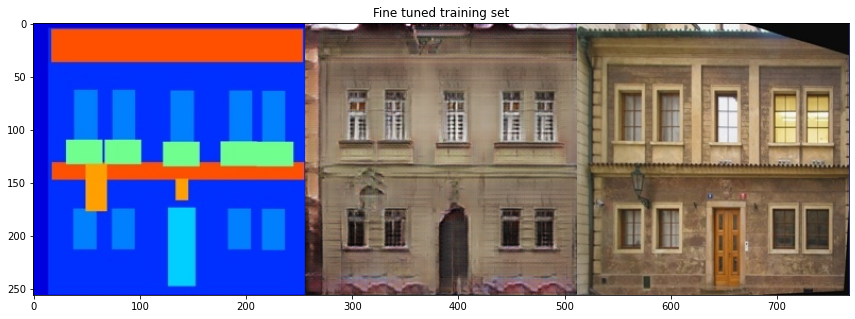

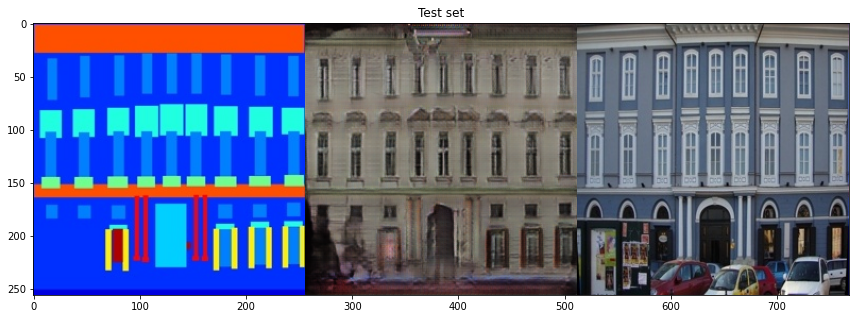

In [36]:
import mmcv
import numpy as np

from mmcv import Config
from mmedit.apis import generation_inference, init_model

# setup the fine-tuned checkpoint file to load
checkpoint = './tutorial_exps/pix2pix_facades_tiny/iter_2000.pth'

# we use the modifed config above
cfg = Config(cfg_bak)

# initialize the synthesizer model using the new config
model = init_model(cfg, checkpoint, device='cuda:0')

# specify the test image (paired, concatenated in the width dimension) paths
img1_path = './data/paired/facades_tiny/train/1.jpg'
img2_path = './data/paired/facades/test/8.jpg'

# perform inference using the high-level api
result1 = generation_inference(model, img1_path)
result2 = generation_inference(model, img2_path)

# constrain the range to [0, 255], and convert the results from float32 to uint8
result1 = np.clip(result1, 0, 255)
result1 = result1.astype(np.uint8)
result2 = np.clip(result2, 0, 255)
result2 = result2.astype(np.uint8)

# visualize
plt.figure(0, figsize=(15, 5))  # set figure size
plt.title('Fine tuned training set') # set title
# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result1))

plt.figure(1, figsize=(15, 5))  # set figure size
plt.title('Test set') # set title
# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result2))

Images from left to right are **masks**, **generated images**, **real images**, respectively. After a relatively short time of fine tuning, we can achieve these results. Not bad!

### Unpaired Image-to-Image Translation (CycleGAN)

#### Prepare A New Unpaired Dataset

As described, we also need to construct a new unpaired dataset to fine tune the CycleGAN pretrained model.

In [37]:
%cd data/unpaired
!mkdir -p horse2zebra_tiny/trainA
!mkdir -p horse2zebra_tiny/trainB
!mkdir -p horse2zebra_tiny/testA
!mkdir -p horse2zebra_tiny/testB
# use a part of the test set (100 images, due to no validation set) of horse2zebra dataset
# as the new small training set, the remaining test images constitute the new test set
import os
import shutil

lstA = sorted(os.listdir('./horse2zebra/testA'))
lstB = sorted(os.listdir('./horse2zebra/testB'))

# new training set
for i in range(100):
  shutil.copy(os.path.join('./horse2zebra/testA', lstA[i]),
              os.path.join('./horse2zebra_tiny/trainA', lstA[i]))
  shutil.copy(os.path.join('./horse2zebra/testB', lstB[i]),
              os.path.join('./horse2zebra_tiny/trainB', lstB[i]))

# new test set
for i in range(100, len(lstA)):
  shutil.copy(os.path.join('./horse2zebra/testA', lstA[i]),
              os.path.join('./horse2zebra_tiny/testA', lstA[i]))
for i in range(100, len(lstB)):
  shutil.copy(os.path.join('./horse2zebra/testB', lstB[i]),
              os.path.join('./horse2zebra_tiny/testB', lstB[i]))

/content/mmediting/data/unpaired


In [38]:
# show the directory structure of the newly constructed dataset
!tree horse2zebra_tiny

horse2zebra_tiny
├── testA
│   ├── n02381460_7190.jpg
│   ├── n02381460_7230.jpg
│   ├── n02381460_7250.jpg
│   ├── n02381460_7300.jpg
│   ├── n02381460_7400.jpg
│   ├── n02381460_7500.jpg
│   ├── n02381460_7620.jpg
│   ├── n02381460_7660.jpg
│   ├── n02381460_7700.jpg
│   ├── n02381460_7890.jpg
│   ├── n02381460_7970.jpg
│   ├── n02381460_800.jpg
│   ├── n02381460_840.jpg
│   ├── n02381460_8900.jpg
│   ├── n02381460_8980.jpg
│   ├── n02381460_900.jpg
│   ├── n02381460_910.jpg
│   ├── n02381460_9240.jpg
│   ├── n02381460_9260.jpg
│   └── n02381460_950.jpg
├── testB
│   ├── n02391049_5990.jpg
│   ├── n02391049_600.jpg
│   ├── n02391049_6180.jpg
│   ├── n02391049_6190.jpg
│   ├── n02391049_640.jpg
│   ├── n02391049_6520.jpg
│   ├── n02391049_6650.jpg
│   ├── n02391049_6690.jpg
│   ├── n02391049_6780.jpg
│   ├── n02391049_6860.jpg
│   ├── n02391049_6890.jpg
│   ├── n02391049_690.jpg
│   ├── n02391049_7060.jpg
│   ├── n02391049_7150.jpg
│   ├── n02391049_7190.jpg
│   ├── n02391049_750.jpg


Horse image size: (256, 256, 3)
Zebra image size: (256, 256, 3)


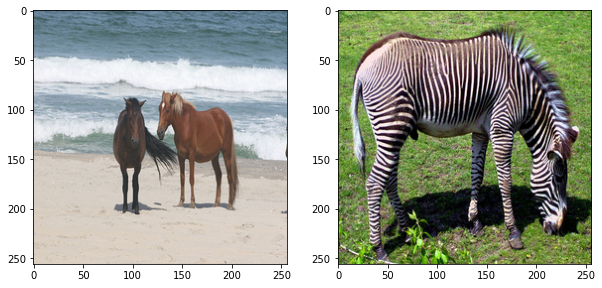

In [39]:
# Also, we can visualize an example
import matplotlib.pyplot as plt
import mmcv

# read the unpaired image
img_horse = mmcv.imread('./horse2zebra_tiny/trainA/n02381460_5500.jpg')
img_zebra = mmcv.imread('./horse2zebra_tiny/trainB/n02391049_3270.jpg')

# show the unpaired image size
print(f'Horse image size: {img_horse.shape}')
print(f'Zebra image size: {img_zebra.shape}')

# visualize the test image 
fig = plt.figure(figsize=(10, 5))  # set figure size
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, the left image  
ax2 = fig.add_subplot(1, 2, 2)  # 1 row, 2 columns, the right image  

# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
ax1.imshow(mmcv.bgr2rgb(img_horse))
ax2.imshow(mmcv.bgr2rgb(img_zebra))

In [40]:
# back to the root and list files
%cd ../..
!ls

/content/mmediting
checkpoints  docker   mmedit.egg-info	resources  tools
configs      docs     README.md		setup.cfg  tutorial_exps
data	     LICENSE  requirements	setup.py
demo	     mmedit   requirements.txt	tests


#### Modify the Training Config

After constructing the new dataset 'horse2zebra_tiny', we need to modify the config file to train a new synthesizer. To save some time, we only train CycleGAN for another 4 epochs.

In [41]:
from mmcv import Config

# specify the config file
config = 'configs/synthesizers/cyclegan/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra.py'

# setup the checkpoint file to fine tune
checkpoint = 'checkpoints/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth'

# load the training config file (the file information has been shown in the inference section)
cfg = Config.fromfile(config)

# modify dataset path (the type and processing pipeline keep unchanged)
cfg.data_root = './data/unpaired/horse2zebra_tiny'
cfg.data.train.dataroot = './data/unpaired/horse2zebra_tiny'
cfg.data.val.dataroot = './data/unpaired/horse2zebra_tiny'
cfg.data.test.dataroot = './data/unpaired/horse2zebra_tiny'

# modify the pretrained model path
cfg.load_from = checkpoint

# modify other training settings
# train for another 4 epochs (400 iterations)
cfg.total_iters = 400
# set new working directory
cfg.exp_name = 'cyclegan_horse2zebra_tiny'
cfg.work_dir = './tutorial_exps/cyclegan_horse2zebra_tiny'
# update learning rate updater config (due to the total inters and training set size change)
cfg.lr_config.start = 200
cfg.lr_config.interval = 50
# update checkpoint itervals to accelerate
cfg.checkpoint_config.interval = 400
# no need for evaluation during training, we can inference after the model is well-trained
# thus, we set a very large value for the interval
cfg.evaluation.interval = 2000000
# set the new log interval
cfg.log_config.interval = 50
# set seed for reproducibility
cfg.seed = 1112

# show the training config file
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='CycleGAN',
    generator=dict(
        type='ResnetGenerator',
        in_channels=3,
        out_channels=3,
        base_channels=64,
        norm_cfg=dict(type='IN'),
        use_dropout=False,
        num_blocks=9,
        padding_mode='reflect',
        init_cfg=dict(type='normal', gain=0.02)),
    discriminator=dict(
        type='PatchDiscriminator',
        in_channels=3,
        base_channels=64,
        num_conv=3,
        norm_cfg=dict(type='IN'),
        init_cfg=dict(type='normal', gain=0.02)),
    gan_loss=dict(
        type='GANLoss',
        gan_type='lsgan',
        real_label_val=1.0,
        fake_label_val=0.0,
        loss_weight=1.0),
    cycle_loss=dict(type='L1Loss', loss_weight=10.0, reduction='mean'),
    id_loss=dict(type='L1Loss', loss_weight=0.5, reduction='mean'))
train_cfg = dict(direction='a2b', buffer_size=50)
test_cfg = dict(direction='a2b', show_input=True)
train_dataset_type = 'GenerationUnpairedDataset'
val_dataset_typ

#### Train A New CycleGAN Synthesizer

In [42]:
import copy
import os
import os.path as osp
import time

import mmcv
import torch
from mmedit import __version__
from mmedit.apis import set_random_seed, train_model
from mmedit.datasets import build_dataset
from mmedit.models import build_model
from mmedit.utils import get_root_logger

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

# set the number of gpus
cfg.gpus = 1

# create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# init the logger before other steps
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

# log some basic info
logger.info('Distributed training: {}'.format(False))
logger.info('mmedit Version: {}'.format(__version__))

# set random seed for reproducibility
logger.info('Set random seed to {}, deterministic: {}'.format(cfg.seed, False))
set_random_seed(cfg.seed, deterministic=False)

# build model
model = build_model(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# build dataset
datasets = [build_dataset(cfg.data.train)]

# prepare some meta information
if cfg.checkpoint_config is not None:
    # save version, config file content and class names in checkpoints as meta data
    cfg.checkpoint_config.meta = dict(
        mmedit_version=__version__,
        config=cfg.text,
    )
meta = dict()
meta['exp_name'] = cfg.exp_name
meta['mmedit Version'] = __version__
meta['seed'] = cfg.seed

# backup the config for inference
cfg_bak = copy.deepcopy(cfg)

# start training a new CycleGAN synthesizer!
train_model(model,
            datasets,
            cfg,
            distributed=False,
            validate=False,
            timestamp=timestamp,
            meta=meta)

2020-10-14 04:27:44,564 - mmedit - INFO - Distributed training: False
2020-10-14 04:27:44,564 - mmedit - INFO - mmedit Version: 0.5.0
2020-10-14 04:27:44,565 - mmedit - INFO - Set random seed to 1112, deterministic: False
/usr/local/lib/python3.6/dist-packages/mmcv/cnn/bricks/conv_module.py:100: UserWarning: ConvModule has norm and bias at the same time
  warnings.warn('ConvModule has norm and bias at the same time')
2020-10-14 04:27:45,413 - mmedit - INFO - load checkpoint from checkpoints/cyclegan_lsgan_resnet_in_1x1_266800_horse2zebra_20200524-1b3d5d3a.pth
2020-10-14 04:27:45,504 - mmedit - INFO - Start running, host: root@b2a8ae642c6a, work_dir: /content/mmediting/tutorial_exps/cyclegan_horse2zebra_tiny
2020-10-14 04:27:45,505 - mmedit - INFO - workflow: [('train', 1)], max: 400 iters
2020-10-14 04:28:15,330 - mmedit - INFO - Iter [50/400]	lr_generators: 2.000e-04 lr_discriminators: 2.000e-04, eta: 0:03:27, time: 0.593, data_time: 0.001, memory: 10530, loss_gan_d_a: 0.1798, loss_ga

#### Understand the Log

From the log, we can get a basic understanding of the training process and know how well the synthesizer is trained.

Similar to pix2pix, from the first few lines, we can see some basic information of our training process, e.g., whether to use distributed training, MMEditing version, random seed, load path, work directory, etc.

By printing out the training status for every 50 iterations, we can observe the learning rates for the generator and discriminator, the estimated time of arrival (`eta`), the step time, the data loading time, the memory consumption, and the different loss values.

We can observe that a linear learning rate updater is used. With this, the learning rate remains fixed for the first 200 iterations. Then, it will linearly decays to 0 for the subsequent 200 iterations. The loss values gradually decrease during training.

Furthermore, as discussed, CycleGAN has a more complex network structure compared to pix2pix, and therefore CycleGAN can support a more difficult task, i.e., unpaired image-to-image translation. As such, we can see that the step time (`time`) for CycleGAN is much longer than that for pix2pix. Even if it trains for much fewer iterations (400) compared to pix2pix (2000), CycleGAN takes a longer training time.

#### Test the New CycleGAN Synthesizer

After we fine tune the CycleGAN synthesizer, let's test again and visualize the predicted results!

/usr/local/lib/python3.6/dist-packages/mmcv/cnn/bricks/conv_module.py:100: UserWarning: ConvModule has norm and bias at the same time
  warnings.warn('ConvModule has norm and bias at the same time')


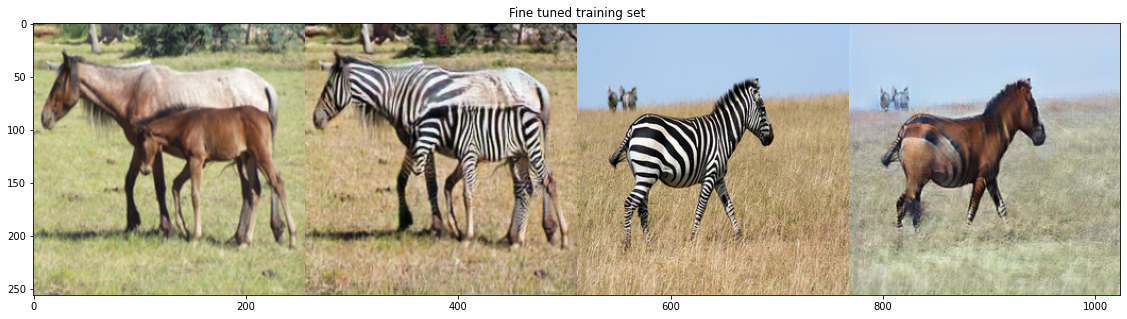

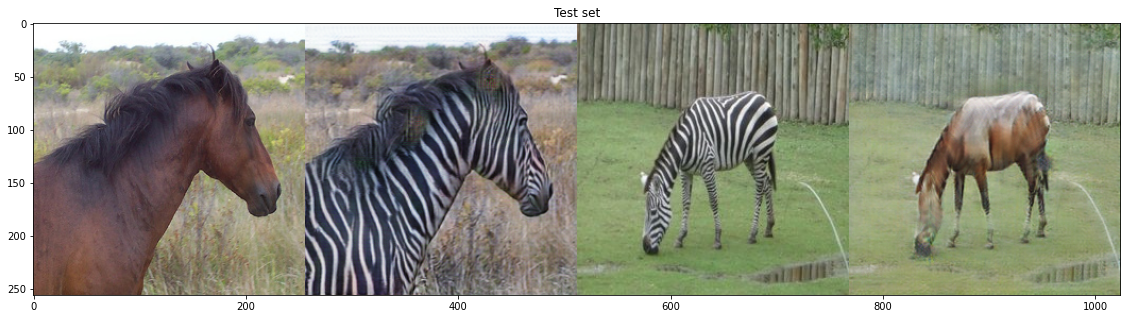

In [44]:
import mmcv
import numpy as np

from mmcv import Config
from mmedit.apis import generation_inference, init_model

# setup the fine-tuned checkpoint file to load
checkpoint = './tutorial_exps/cyclegan_horse2zebra_tiny/iter_400.pth'

# we use the modifed config above
cfg = Config(cfg_bak)

# initialize the synthesizer model using the new config
model = init_model(cfg, checkpoint, device='cuda:0')

# specify the test image (two unpaired images) paths
img1_a_path = './data/unpaired/horse2zebra_tiny/trainA/n02381460_1920.jpg'
img1_b_path = './data/unpaired/horse2zebra_tiny/trainB/n02391049_1880.jpg'
img2_a_path = './data/unpaired/horse2zebra_tiny/testA/n02381460_7230.jpg'
img2_b_path = './data/unpaired/horse2zebra_tiny/testB/n02391049_6890.jpg'

# perform inference using the high-level api
result1 = generation_inference(model, img1_a_path, img1_b_path)
result2 = generation_inference(model, img2_a_path, img2_b_path)

# constrain the range to [0, 255], and convert the results from float32 to uint8
result1 = np.clip(result1, 0, 255)
result1 = result1.astype(np.uint8)
result2 = np.clip(result2, 0, 255)
result2 = result2.astype(np.uint8)

# visualize the test image 
plt.figure(0, figsize=(20, 5))  # set figure size
plt.title('Fine tuned training set') # set title
# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result1))

plt.figure(1, figsize=(20, 5))  # set figure size
plt.title('Test set') # set title
# mmcv(cv2) loads images in [B, G, R] format, we change it back to [R, G, B]
plt.imshow(mmcv.bgr2rgb(result2))

Images from left to right are **real horses**, **fake zebras**, **real zebras**, **fake horses**, respectively. After a relatively short time of fine tuning, we can achieve the above results. Considering the difficulty of unpaired image-to-image translation, the results are acceptable although the model produces some small artifacts when performing zebra -> horse translation.

## What to Do Next?

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  train for longer to see how good the results get.
-  try different datasets and make possible changes in the
   size of the images and the model architecture.
-  explore more paired image-to-image translation methods, such as [pix2pixHD](https://github.com/NVIDIA/pix2pixHD), [SPADE](https://github.com/NVlabs/SPADE), etc.
-  explore more unpaired image-to-image translation methods, such as [UNIT](https://github.com/mingyuliutw/UNIT), [MUNIT](https://github.com/NVlabs/MUNIT), [StarGAN](https://github.com/yunjey/stargan), etc.
-  learn about some very recent advances on versatile conditional image generation, e.g., [Semantic Pyramid](https://semantic-pyramid.github.io/), [TSIT](https://github.com/EndlessSora/TSIT).

We hope these will be of help to you!